In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# 훈련 데이터셋 확인
train = pd.read_csv('Titanic/input/train.csv')
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
print('\n ### 훈련 데이터셋 정보 ### \n')
print(train.info())


 ### 훈련 데이터셋 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


Age, Cabin, Embarked 컬럼에서 Null 값이 있는데 머신러닝 모델에는 Null값을 허용하지 않기 때문에 이를 어떻게 처리할지 결정해야함

In [4]:
### Age는 평균값으로 대체
train['Age'].fillna(train['Age'].mean(), inplace = True)

### 나머지는 'N'으로 대체
train['Cabin'].fillna('N', inplace=True)
train['Embarked'].fillna('N', inplace=True)
print('데이터 Null 값 개수: ', train.isnull().sum().sum())

데이터 Null 값 개수:  0


Sex, Cabin, Embarked --> 세 가지 문자열 Feature에 대해 값과 데이터 수 살펴보기

In [5]:
print('Sex 값 분포 :\n', train['Sex'].value_counts())
print('\nCabin 값 분포: \n', train['Cabin'].value_counts())
print('\nEmbarked 값 분포: \n', train['Embarked'].value_counts())

Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

Cabin 값 분포: 
 N              687
G6               4
C23 C25 C27      4
B96 B98          4
E101             3
D                3
F33              3
C22 C26          3
F2               3
C83              2
B28              2
B58 B60          2
B49              2
C125             2
E121             2
E44              2
C52              2
C2               2
B5               2
E67              2
C126             2
D36              2
D26              2
C65              2
B20              2
D35              2
C68              2
C78              2
C92              2
B77              2
              ... 
B42              1
D21              1
E49              1
A34              1
C99              1
D6               1
A19              1
B86              1
B50              1
D37              1
E58              1
E63              1
E50              1
D47              1
C49              1
D56              1
D7               1
B82 B84  

Sex와 Embarked 값은 크게 문제가 없으나, Cabin의 경우 N이 687건으로 가장 많음

Cabin은 첫 번째 글자가 좌석의 등급 등과 연관이 있을 수도 있으므로 첫 글자만 추출

In [6]:
train['Cabin'] = train['Cabin'].str[:1]
print(train['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


이번에는 성별에 따른 생존자 수를 비교

In [7]:
train.groupby(['Sex','Survived'])['Survived'].count().to_frame()

Survived
Sex    Survived          
female 0               81
       1              233
male   0              468
       1              109

Survived는 예측의 대상이 되는 타겟 컬럼으로 0이면 사망, 1이면 생존

여자는 81/233 = 74.2% 가량 생존했고, 남자는 109/577 = 18.8% 생존

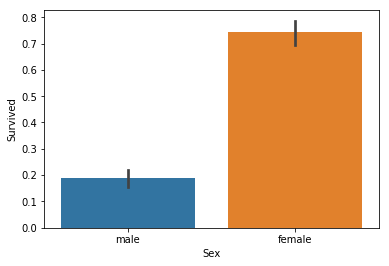

In [8]:
sns.barplot(x='Sex', y='Survived', data=train)

부자와 가난한 사람의 생존률 차이는 어떤지 살펴보기 --> Pclass+Sex

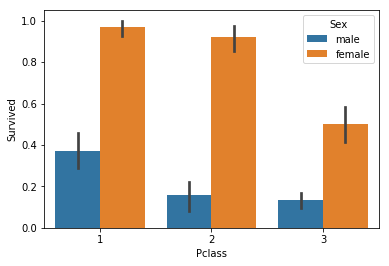

In [9]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train)

여성의 경우 1, 2등급 모두 생존률이 높고 3등급으로 가면 생존률이 많이 떨어짐
남성의 경우도 등급이 좋을 수록 생존률이 높으나, 남성 1등급의 생존률이 여성 3등급의 생존률보다 낮음

이번에는 Age에 따른 생존 확률

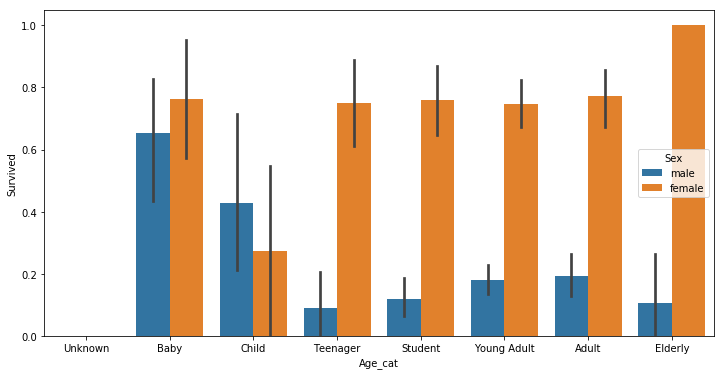

In [10]:
# Age 값에 따라 연령층을 분류하는 함수 정의. 이후 apply lambda에 이용

def get_category(age):
    cat = ''
    if age <= -1 : cat = 'Unknown'
    elif age <= 5 : cat = 'Baby'
    elif age <= 12 : cat = 'Child'
    elif age <= 18 : cat = 'Teenager'
    elif age <= 25 : cat = 'Student'
    elif age <= 35 : cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

# barplot 크게 설정
plt.figure(figsize=(12, 6))

# X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 반환 값으로 지정
# get_category(x)는 입력값으로 Age 컬럼 값을 받아서 해당되는 cat 반환
train['Age_cat'] = train['Age'].apply(lambda x: get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=train, order=group_names)
train.drop('Age_cat', axis=1, inplace=True)


여자 Baby의 경우에는 비교적 생존률이 높고, Child의 경우 생존률이 낮음, Elderly의 경우에는 생존률이 매우 높음

Sex, Age, Pclass 등이 생존 여부에 중요한 Feature인 것으로 보임

이제 남아있는 문자열 카테고리 Feature를 숫자형으로 변환 --> 사이킷런의 LabelEncoder() 이용
 
  - LabelEncoder 객체는 카테고리 값의 유형수에 따라 0 ~ (유형수-1) 까지 숫자 값으로 변환

In [11]:
from sklearn.preprocessing import LabelEncoder

def encode_features(dataDF) :
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

train = encode_features(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


지금까지 Feature를 가공한 내역을 정리하여 함수로 다시 정리

In [12]:
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df


# 러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df


# 라벨 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

다시 원본 데이터를 호출해서 transform_features 함수로 가공해보기

In [13]:
# 원본 데이터 재로딩
titanic_df = pd.read_csv('Titanic/input/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop(['Survived'], axis=1)

X_titanic_df = transform_features(X_titanic_df)

내려받은 학습 세트를 기반으로 하여 train_test_split() 을 이용하여 별도의 테스트 데이터 세트를 추출

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 11)

ML 알고리즘인 DecisionTree, RandomForest, Logistic Regression을 이용하여 생존자 예측
 - train_test_split() 으로 분리한 학습 데이터와 테스트 데이터를 기반으로 머신러닝 모델을 학습(fit)하고, 예측(predict)
 - 성능평가는 정확도로 평가: accuracy_score() 를 사용

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# DecisionTree, RandomForest, LogisticRegression을 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
      
# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test,rf_pred)))
      
# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도 : {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도 : 0.7877
RandomForestClassifier 정확도 : 0.8324
LogisticRegression 정확도 : 0.8659


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3개의 알고리즘 중 Logistioc Regression이 높은 정확도를 나타내고 있음

하지만 아직 최적화 작업을 수행하지 않았고, 데이터 양도 충분치 않기 때문에 어떤 알고리즘이 가장 좋은 성능인지 평가할 수는 없음

교차 검증을 위한 kFold 클래스를 사용

In [16]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds):
    # 폴드 세트가 5개인 kFold 객체 생성, 폴드 수 만큼 예측결과 저장을 위한 리스트 객체 생성
    kfold = KFold(n_splits=folds)
    scores = []
    
    # kFold 교차검증 수행
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_train_df 데이터에서 교차검증별로 학습과 검증 데이터를 가리키는 인덱스 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        # Classifier 학습, 예측, 정확도 계산
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
        # 5개 fold에서 평균 정확도 계산
    mean_score = np.mean(scores)
    print("평균 정확도 : {0:.4f}".format(mean_score))
    
# exec_kfold 호출
exec_kfold(dt_clf, 5)

교차검증 0 정확도: 0.7542
교차검증 1 정확도: 0.7809
교차검증 2 정확도: 0.7865
교차검증 3 정확도: 0.7697
교차검증 4 정확도: 0.8202
평균 정확도 : 0.7823


교차 검증을 위한 cross_val_score() 사용

In [17]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
    print("교차검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
    
print("평균정확도: {0: .4f}".format(np.mean(scores)))

교차검증 0 정확도: 0.7430
교차검증 1 정확도: 0.7765
교차검증 2 정확도: 0.7809
교차검증 3 정확도: 0.7753
교차검증 4 정확도: 0.8418
평균정확도:  0.7835


kFold와 cross_val_score의 점수가 다른 것은, cross_val_score 는 StratifiedKFold를 이용해 세트를 분할하기 때문

GridSearchCV를 이용하여 DecisionTreeClassifier 최적 하이퍼 파라미터를 찾고, 예측 성능을 측정
 - CV = 5로 지정하고, max_depth, min_samples_split, min_samples_leaf를 변경하면서 성능을 측정
 - 최적 하이퍼 파라미터와 그 때의 예측을 출력하고, 최적 하이퍼파라미터로 학습된 Estimator를 이용해 위의 train_test_split()으로 분리된 테스트 데이터 세트에 예측을 수행하여 정확도 측정

In [18]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [2, 3, 5, 10],
                        'min_samples_split' : [2, 3, 5],
                         'min_samples_leaf' : [1, 5, 8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print("GridSearch 최적 하이퍼 파라미터: ", grid_dclf.best_params_)
print("GridSearch 최고 정확도:{:.4f} ".format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearch의 최적 하이퍼파라미터로 학습된 Estimator로 예측 및 평가 수행
predictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy))

GridSearch 최적 하이퍼 파라미터:  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearch 최고 정확도:0.7992 
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8715


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


최적 하이퍼 파라미터인 max_depth =  3, min_samples_leaf = 1, min_samples_split =  2 로 DecisionClassifier를 학습시킨 뒤 모델 정확도가 약 87.15%로 향상

실제로는 하이퍼 파라미터 튜닝으로 스코어가 이렇게 증가하지는 않음